In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from sklearn.cross_validation import cross_val_score
from time import time
from sklearn.preprocessing import Normalizer

In [2]:
file_path = '/data/opinion_spam/real/reviewsNew.txt-utf8'
datas = []
MIN_FD = 100
raw_file = open(file_path)
debug = False
debug_size = 100
_debug_count = 0
for line in raw_file:    
    try:
        line = line.decode('gbk')
    except:
        continue
    #print 'gbk', line
    line = line.encode('utf-8')
    #print 'utf8', line
    item = line.split('\t')
    if len(item) == 8:
        hfd = float(item[3])
        fd = float(item[4])
        ratings = float(item[5])
        if fd > MIN_FD:
            hfdfd = round(hfd/fd, 2)
            #whole_filted_body += item[7]
            item.append(hfdfd)
            datas.append(item)
            if debug == True:
                _debug_count += 1
                if _debug_count >= debug_size:
                    break
raw_file.close()
print 'datas.size: ', len(datas)
print datas[0]

datas.size:  19030
['A1004AX2J2HXGL', 'B00003CWPL', 'December 2, 2003', '111', '125', '5.0', '"But what the hell do they know, I said?"', ' If you\'re reading this, then you\'ve seen this movie or are at least curious what all the hype is about?    The late Stanley Kubrick, the only major filmmaker Lynch has cited as a direct cinematic influence, believed that ERASERHEAD was one of the most perfect "cinematic experiences" created to date.  This movie has enjoyed success on the midnight movie circuit for years, particularly in NYC where it ran almost every night for something like five years straight. I\'ve seen it on big and little screens in three different states.  Insofar as interpretations are concerned, I\'ve long since tossed all that out the window.  In terms of rational comprehension, ERASERHEAD is the fabled big fish that remains brilliantly elusive of any attempts to capture it.     This movie gets better, and more humorous, every time I watch it: in my opinion - ERASERHEAD i

In [3]:
#set column names
column_names = ['rid', 'pid', 'date', 'hfd', 'fd', 'rating', 'title', 'body', 'hfdfd']
df = pd.DataFrame(datas)
df.columns = column_names

#transfer the type of column
df[['hfd', 'fd','rating']] = df[['hfd', 'fd', 'rating']].astype(float)

df.head()


,rid,pid,date,hfd,fd,rating,title,body,hfdfd
0,A1004AX2J2HXGL,B00003CWPL,"December 2, 2003",111,125,5,"""But what the hell do they know, I said?""","If you're reading this, then you've seen this...",0.89
1,A103PHKSEPT10R,0939484463,"July 5, 2000",69,116,5,"Credible, Interesting, & Devasting",I've read Prof Butz's book twice and an still...,0.59
2,A103U0Q3IKSXHE,0875845851,"January 29, 2000",111,115,4,Identifying the horns of the dilemma.,"Prior to reading this book, I chalked up the ...",0.97
3,A105YVLAZNYQUU,B000634DCW,"June 21, 2005",6,112,1,UGGHHH,Craptacular and boring. The cinematography an...,0.05
4,A1075MZNVRMSEO,1563249367,"April 2, 2002",190,190,5,A historical portrait & revelation- un chin de...,This book is a fascinating journey through th...,1.00


In [4]:
df.describe()

,hfd,fd,rating,hfdfd
count,19030.000000,19030.000000,19030.000000,19030.000000
mean,123.107672,175.208618,3.517236,0.686647
std,136.356483,148.217463,1.690639,0.332032
min,0.000000,101.000000,1.000000,0.000000
25%,56.000000,114.000000,2.000000,0.390000
50%,106.000000,138.000000,4.000000,0.860000
75%,147.000000,186.000000,5.000000,0.970000
max,8026.000000,8262.000000,5.000000,1.000000


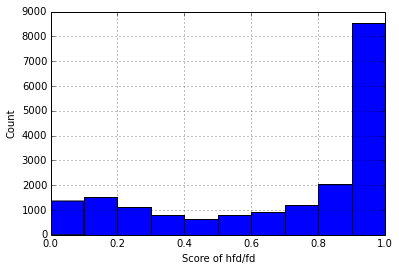

In [5]:
#hfdfd distribution
df.hfdfd.hist()
plt.title='The Distribute of hfd/fd'
plt.xlabel('Score of hfd/fd')
plt.ylabel('Count')

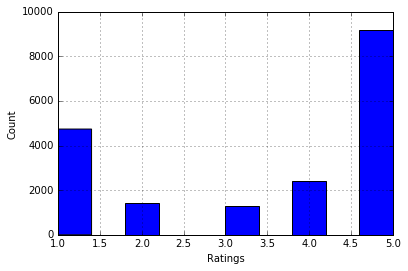

In [5]:
#rating distribution
df.rating.hist()
plt.xlabel('Ratings')
plt.ylabel("Count")
plt.savefig('ratings.svg')

In [6]:
#count how many products in the dataset  ==》9809 products
df.groupby('pid').count().shape
print 'different product size:', df.groupby('pid').count().shape[0] 

different product size: 9805


In [7]:
df.shape

(19030, 9)

In [16]:
def split(sentence):
    return len(sentence.split())

In [17]:
df['title_len'] = df['title'].apply(len)
df['body_len'] = df['body'].apply(len)
df['body_word_count'] = df['body'].apply(split)

In [18]:
df.head()

,rid,pid,date,hfd,fd,rating,title,body,hfdfd,title_len,body_len,body_word_count
0,A1004AX2J2HXGL,B00003CWPL,"December 2, 2003",111,125,5,"""But what the hell do they know, I said?""","If you're reading this, then you've seen this...",0.89,41,2642,434
1,A103PHKSEPT10R,0939484463,"July 5, 2000",69,116,5,"Credible, Interesting, & Devasting",I've read Prof Butz's book twice and an still...,0.59,34,313,55
2,A103U0Q3IKSXHE,0875845851,"January 29, 2000",111,115,4,Identifying the horns of the dilemma.,"Prior to reading this book, I chalked up the ...",0.97,37,1495,237
3,A105YVLAZNYQUU,B000634DCW,"June 21, 2005",6,112,1,UGGHHH,Craptacular and boring. The cinematography an...,0.05,6,1045,192
4,A1075MZNVRMSEO,1563249367,"April 2, 2002",190,190,5,A historical portrait & revelation- un chin de...,This book is a fascinating journey through th...,1.00,59,2180,344


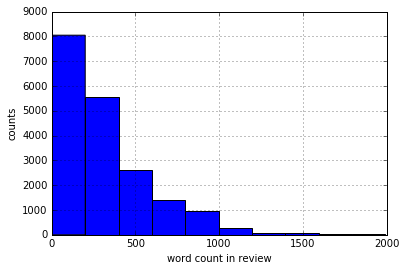

In [21]:
df[df['body_word_count'] < 2000]['body_word_count'].hist()
plt.xlabel('word count in review')
plt.ylabel('counts')

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


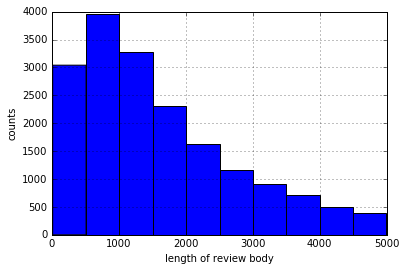

In [11]:
df[df['body_len'] > 10][df['body_len'] < 5000]['body_len'].hist()
plt.xlim(0, 5000)
plt.xlabel("length of review body")
plt.ylabel("review count")
plt.savefig('review_length_distribution.svg')

In [13]:
df[['title_len', 'body_len']].describe()

,title_len,body_len
count,19030.000000,19030.000000
mean,32.753127,1883.683710
std,14.986119,1674.283969
min,0.000000,9.000000
25%,21.000000,715.000000
50%,31.000000,1383.000000
75%,44.000000,2533.750000
max,128.000000,26425.000000


# TFIDF features

In [5]:
#TFIDF feature without lsa

import evaluation_self as es
max_features_count = 10000
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.5, max_features=max_features_count,
                                 min_df=2, stop_words='english', tokenizer = es.tokenize_and_stem)

tfidf_matrix = vectorizer.fit_transform(df.body)
print "the tfidf matrix size : ",tfidf_matrix.shape
print type(tfidf_matrix)


the tfidf matrix size :  (19030, 10000)
<class 'scipy.sparse.csr.csr_matrix'>


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [15]:
#TFIDF-CV-10-lsvr
from sklearn.svm import LinearSVR

lsvr = LinearSVR()



scores2 = cross_val_score(lsvr, tfidf_matrix, df.hfdfd, cv=10, scoring="mean_squared_error")

mse2 = abs(scores2)
print 'TFIDF-cv10-LSVR, mse:', mse2
print 'TFIDF-cv10-LSVR, mse mean:', np.mean(mse2)
print 'TFIDF-cv10-LSVR, rmse:', np.sqrt(mse2)
print 'TFIDF-cv10-LSVR, rmse mean:', np.mean(np.sqrt(mse2))

TFIDF-cv10-LSVR, mse: [ 0.06440026  0.06995006  0.07005705  0.07386458  0.07330366  0.06633243
  0.07306818  0.08394087  0.15534793  0.08458308]
TFIDF-cv10-LSVR, mse mean: 0.0814848111148
TFIDF-cv10-LSVR, rmse: [ 0.25377207  0.26448074  0.26468293  0.27178038  0.27074649  0.25755084
  0.27031127  0.28972552  0.39414201  0.2908317 ]
TFIDF-cv10-LSVR, rmse mean: 0.282802394747


In [16]:
#TFIDF-CV-10-svr
from sklearn.svm import SVR

svr = SVR()

from sklearn.cross_validation import cross_val_score

scores2 = cross_val_score(svr, tfidf_matrix, df.hfdfd, cv=10, scoring="mean_squared_error")

mse2 = abs(scores2)
print 'TFIDF-cv10-SVR, mse:', mse2
print 'TFIDF-cv10-SVR, mse mean:', np.mean(mse2)
print 'TFIDF-cv10-SVR, rmse:', np.sqrt(mse2)
print 'TFIDF-cv10-SVR, rmse mean:', np.mean(np.sqrt(mse2))

TFIDF-cv10-SVR, mse: [ 0.06535288  0.08267146  0.0836586   0.08762576  0.09181428  0.09191942
  0.10392582  0.15176034  0.34089973  0.1576381 ]
TFIDF-cv10-SVR, mse mean: 0.125726639572
TFIDF-cv10-SVR, rmse: [ 0.25564209  0.28752646  0.28923797  0.29601648  0.3030087   0.30318216
  0.32237528  0.3895643   0.5838662   0.39703665]
TFIDF-cv10-SVR, rmse mean: 0.342745628241


In [95]:
#TFIDF-CV-10-lr
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

from sklearn.cross_validation import cross_val_score

scores2 = cross_val_score(lr, tfidf_matrix, df.hfdfd, cv=10, scoring="mean_squared_error")

mse2 = abs(scores2)
print 'TFIDF-cv10-LR, mse:', mse2
print 'TFIDF-cv10-LR, mse mean:', np.mean(mse2)
print 'TFIDF-cv10-LR, rmse:', np.sqrt(mse2)
print 'TFIDF-cv10-LR, rmse mean:', np.mean(np.sqrt(mse2))

TFIDF-cv10-LR, mse: [ 0.13498981  0.1361512   0.13288354  0.13928257  0.13139293  0.12897797
  0.1218409   0.14413322  0.20896691  0.14242456]
TFIDF-cv10-LR, mse mean: 0.142104362512
TFIDF-cv10-LR, rmse: [ 0.36740959  0.36898672  0.36453195  0.37320581  0.36248163  0.35913503
  0.34905716  0.37964881  0.45712899  0.37739178]
TFIDF-cv10-LR, rmse mean: 0.375897748311


In [96]:
#TFIDF-CV-10-LGR
from sklearn.linear_model import LogisticRegression

tfidf_lgr = LogisticRegression()

from sklearn.cross_validation import cross_val_score

scores2 = cross_val_score(tfidf_lgr, tfidf_matrix, df.hfdfd, cv=10, scoring="mean_squared_error")

mse2 = abs(scores2)
print 'TFIDF-cv10-LGR, mse:', mse2
print 'TFIDF-cv10-LGR, mse mean:', np.mean(mse2)
print 'TFIDF-cv10-LGR, rmse:', np.sqrt(mse2)
print 'TFIDF-cv10-LGR, rmse mean:', np.mean(np.sqrt(mse2))

ValueError: Unknown label type: array([ 0.5 ,  0.94,  0.46, ...,  0.23,  0.28,  0.28])

# TFIDF - LSA features

In [18]:
#TFIDF feature without lsa

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline


import evaluation_self as es
max_features_count = 10000
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.5, max_features=max_features_count,
                                 min_df=2, stop_words='english', tokenizer = es.tokenize_and_stem)
lsa_tfidf_matrix = vectorizer.fit_transform(df.body)
print "the tfidf matrix size : ",tfidf_matrix.shape
print type(tfidf_matrix)

lsaornot = True
lsanum = 1000

if lsaornot:
    print "Performing dimensionality reduction using LSA"
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(lsanum)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    lsa_tfidf_matrix = lsa.fit_transform(tfidf_matrix)

    print "done in ", (time() - t0)
    explained_variance = svd.explained_variance_ratio_.sum()
    print "Explained variance of the SVD step:", int(explained_variance * 100)


the tfidf matrix size :  (19030, 10000)
<class 'scipy.sparse.csr.csr_matrix'>
Performing dimensionality reduction using LSA
done in  157.651656866
Explained variance of the SVD step: 46


In [19]:
#TFIDF-LSA-cv10-LR
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

from sklearn.cross_validation import cross_val_score

scores2 = cross_val_score(lr, lsa_tfidf_matrix, df.hfdfd, cv=10, scoring="mean_squared_error")

mse2 = abs(scores2)
print 'TFIDF-LSA-cv10-LR, mse:', mse2
print 'TFIDF-LSA-cv10-LR, mse mean:', np.mean(mse2)
print 'TFIDF-LSA-cv10-LR, rmse2:', np.sqrt(mse2)
print 'TFIDF-LSA-cv10-LR, rmse2 mean:', np.mean(np.sqrt(mse2))

TFIDF-LSA-cv10-LR, mse: [ 0.04775713  0.04903606  0.05047991  0.0514033   0.0526344   0.05189747
  0.05573882  0.06658255  0.12604175  0.0630876 ]
TFIDF-LSA-cv10-LR, mse mean: 0.0614658994003
TFIDF-LSA-cv10-LR, rmse2: [ 0.21853406  0.22144087  0.22467734  0.22672296  0.22942188  0.22781016
  0.2360907   0.25803595  0.35502359  0.25117246]
TFIDF-LSA-cv10-LR, rmse2 mean: 0.244892997013


In [20]:
#TFIDF-LSA-CV-10-lsvr
from sklearn.svm import LinearSVR

lsvr = LinearSVR()

from sklearn.cross_validation import cross_val_score

scores2 = cross_val_score(lsvr, lsa_tfidf_matrix, df.hfdfd, cv=10, scoring="mean_squared_error")

mse2 = abs(scores2)
print 'TFIDF-cv10-LSVR, mse:', mse2
print 'TFIDF-cv10-LSVR, mse mean:', np.mean(mse2)
print 'TFIDF-cv10-LSVR, rmse:', np.sqrt(mse2)
print 'TFIDF-cv10-LSVR, rmse mean:', np.mean(np.sqrt(mse2))

TFIDF-cv10-LSVR, mse: [ 0.04706344  0.04842984  0.04951525  0.05136967  0.05365365  0.05135588
  0.05463498  0.07197216  0.16755377  0.06823578]
TFIDF-cv10-LSVR, mse mean: 0.0663784410568
TFIDF-cv10-LSVR, rmse: [ 0.21694109  0.22006781  0.22252022  0.22664879  0.23163258  0.22661835
  0.23374127  0.26827627  0.40933332  0.26121979]
TFIDF-cv10-LSVR, rmse mean: 0.251699948346


In [21]:
#TFIDF-LSA-CV-10-svr
t0 = time()
from sklearn.svm import SVR

svr = SVR()

from sklearn.cross_validation import cross_val_score

scores2 = cross_val_score(svr, lsa_tfidf_matrix, df.hfdfd, cv=10, scoring="mean_squared_error")

mse2 = abs(scores2)
print 'TFIDF-cv10-SVR, mse:', mse2
print 'TFIDF-cv10-SVR, mse mean:', np.mean(mse2)
print 'TFIDF-cv10-SVR, rmse:', np.sqrt(mse2)
print 'TFIDF-cv10-SVR, rmse mean:', np.mean(np.sqrt(mse2))
print "tfidf-svr cost:", (time() - t0)

TFIDF-cv10-SVR, mse: [ 0.04685083  0.05799732  0.05916522  0.06005656  0.06334367  0.06327406
  0.06980021  0.10013036  0.24981056  0.10239213]
TFIDF-cv10-SVR, mse mean: 0.087282091318
TFIDF-cv10-SVR, rmse: [ 0.21645053  0.24082632  0.24323902  0.2450644   0.25168167  0.25154335
  0.26419729  0.31643382  0.49981052  0.3199877 ]
TFIDF-cv10-SVR, rmse mean: 0.284923463462
tfidf-svr cost: 2887.58699608


# STD features

In [6]:
#STD features

import nltk
import re

def seg_sentence(text):
    sentences = nltk.sent_tokenize(text)
    return [s.strip() for s in sentences if(len(s)) > 0]

def marks_num(text, pattern):
    return len(re.findall(pattern, text))

std_exc = 0
def std_feature(text): # std in Yang@acl-2015
#    print '==============================='
    ary = [0, 0, 0, 0, 0]
    try:
        tokens = es.tokenize_and_stem(text)
        token_num = len(tokens)
    #    print 'token size:', token_num
        sentences = seg_sentence(text)
        sen_num = len(sentences)
    #    print 'sentence size:', sen_num
        avg_sentence_len = np.mean([len(x) for x in sentences])
    #    print 'avg sentence length:', avg_sentence_len
        exc_num = marks_num(text, r'[!！]')
    #    print 'exclamation marks count:', exc_num
        que_num = marks_num(text, r'[？?]')
    #    print 'question percentage:', float(que_num) / sen_num
        ary = [token_num, sen_num, avg_sentence_len, exc_num, que_num]
#         print ary
    except:
#         print text
        std_exc += 1
    finally:
        return ary
    
for loc in range(1, 10):
    print std_feature(df.body.head(10)[loc])

[46, 3, 100.33333333333333, 0, 0]
[152, 12, 122.08333333333333, 0, 0]
[118, 12, 85.333333333333329, 0, 3]
[173, 11, 196.36363636363637, 1, 0]
[122, 15, 77.933333333333337, 1, 1]
[255, 21, 134.38095238095238, 0, 1]
[47, 3, 101.0, 1, 0]
[110, 6, 155.16666666666666, 0, 0]
[151, 13, 117.84615384615384, 0, 2]


In [7]:
#generate std features


X_std = np.array(df.body)
print type(X_std)
X_std = np.array(map(std_feature, X_std))
print "std exception: ", std_exc

print type(X_std)
print X_std.shape

from sklearn.preprocessing import Normalizer
std_normalizer = Normalizer().fit(X_std)
X_std = std_normalizer.transform(X_std)

print std_normalizer

<type 'numpy.ndarray'>
std exception:  0
<type 'numpy.ndarray'>
(19030, 5)
Normalizer(copy=True, norm='l2')


In [24]:
#std-cv10-lr
from sklearn.linear_model import LinearRegression
std_lr = LinearRegression()

std_scores = cross_val_score(std_lr, X_std, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD-cv10-LR, mse:', std_mse
print 'STD-cv10-LR, mse mean:', np.mean(std_mse)
print 'STD-cv10-LR, rmse:', np.sqrt(std_mse)
print 'STD-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))

STD-cv10-LR, mse: [ 0.06360189  0.07989133  0.07838331  0.07714385  0.07993902  0.08373044
  0.09431994  0.10551602  0.19718176  0.10004243]
STD-cv10-LR, mse mean: 0.0959749978122
STD-cv10-LR, rmse: [ 0.25219414  0.28265054  0.2799702   0.27774782  0.28273489  0.28936212
  0.30711551  0.32483229  0.44405153  0.31629485]
STD-cv10-LR, rmse mean: 0.305695389148


In [25]:
#std-cv10-lsvr
from sklearn.svm import LinearSVR
std_lsvr = LinearSVR()

std_scores = cross_val_score(std_lsvr, X_std, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD-cv10-LSVR, mse:', std_mse
print 'STD-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'STD-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'STD-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))

STD-cv10-LSVR, mse: [ 0.06474038  0.08843418  0.08680988  0.08267057  0.08924617  0.08927425
  0.09514427  0.12619244  0.26468182  0.12690577]
STD-cv10-LSVR, mse mean: 0.111409972824
STD-cv10-LSVR, rmse: [ 0.25444131  0.29737884  0.29463516  0.28752491  0.29874098  0.29878797
  0.30845465  0.35523576  0.51447237  0.35623836]
STD-cv10-LSVR, rmse mean: 0.326591030215


In [26]:
#std-cv10-svr
t0 = time()
from sklearn.svm import SVR
std_svr = SVR()

std_scores = cross_val_score(std_svr, X_std, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD-cv10-SVR, mse:', std_mse
print 'STD-cv10-SVR, mse mean:', np.mean(std_mse)
print 'STD-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'STD-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))
print "STD-svr cost:", (time() - t0)

STD-cv10-SVR, mse: [ 0.06177696  0.08301513  0.08118012  0.07895403  0.08446316  0.08398137
  0.093753    0.1185973   0.24350073  0.11979702]
STD-cv10-SVR, mse mean: 0.104901884265
STD-cv10-SVR, rmse: [ 0.24854972  0.28812347  0.28492125  0.28098759  0.29062546  0.2897954
  0.30619112  0.34437959  0.49345793  0.34611707]
STD-cv10-SVR, rmse mean: 0.317314861436
STD-svr cost: 164.936227083


In [9]:
#def cut sentence
stop_words = 'a,able,about,across,after,all,almost,also,am,among,an,and,any,are,as,at,be,because,been,but,by,can,cannot,could,dear,did,do,does,either,else,ever,every,for,from,get,got,had,has,have,he,her,hers,him,his,how,however,i,if,in,into,is,it,its,just,least,let,like,likely,may,me,might,most,must,my,neither,no,nor,not,of,off,often,on,only,or,other,our,own,rather,said,say,says,she,should,since,so,some,than,that,the,their,them,then,there,these,they,this,tis,to,too,twas,us,wants,was,we,were,what,when,where,which,while,who,whom,why,will,with,would,yet,you,your'
stop_words_list = stop_words.split(',')

def cut_into_tokens(text):

    _list = [word.lower() for sentence in nltk.sent_tokenize(text) for word in sentence.split()]
    _list = [re.sub(r'[.?!\'",)(;&%:]', '', word) for word in _list  ]
    _list = [word for word in _list if word not in stop_words_list and len(word) > 0]
    return _list

# Syntactic features of Kim

In [10]:
#Syntactic features of Kim

text = df.body.head(1)[0]
print text
#print nltk.pos_tag([word  for sentence in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sentence)])

def pos_count(text):
    poses = nltk.pos_tag(cut_into_tokens(text))
#     poses = nltk.pos_tag([word  for sentence in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sentence)])
    pos_dict = {}
    for (word, pos) in poses:
        if pos in pos_dict:
            pos_dict[pos] = pos_dict[pos] + 1
        else:
            pos_dict[pos] = 1
    return pos_dict

pos_dict = pos_count(text)#per sentence per second!!!!
# for pos in pos_dict:
#     print pos, " => ", pos_dict[pos]
# print 'aa'
syn_exc = 0

def fetch_count_from_pos_dict(pos_list, pos_dict):
    _pos_count = 0
    for pos in pos_list:
        if pos in pos_dict:
            _pos_count += pos_dict[pos]
    return _pos_count

def syntactic_feature(text): #syn feature function
    ary = [0, 0, 0, 0]
    try:
        pos_dict = pos_count(text)
        nn_count = fetch_count_from_pos_dict(['NN', 'NNS', 'NNP', 'NNPS'], pos_dict)#noun
        jj_count = fetch_count_from_pos_dict(['JJ', 'JJR', 'JJS'], pos_dict)#adj
        vb_count = fetch_count_from_pos_dict(['VB', 'VBD', 'VBG', 'VBN', 'VNP', 'VBZ'], pos_dict)#vb
        rb_count = fetch_count_from_pos_dict(['RB', 'RBR', 'RBS'], pos_dict)#adv
        ary = [nn_count, jj_count, vb_count, rb_count]
    except:
        print 'error'
        syn_exc += 1
    finally:
        return ary
# print 't_dict', pos_dict['_t_dict']
for _text in df.body.head(10):
    print syntactic_feature(_text)
print 'syn_exc is ', syn_exc

 If you're reading this, then you've seen this movie or are at least curious what all the hype is about?    The late Stanley Kubrick, the only major filmmaker Lynch has cited as a direct cinematic influence, believed that ERASERHEAD was one of the most perfect "cinematic experiences" created to date.  This movie has enjoyed success on the midnight movie circuit for years, particularly in NYC where it ran almost every night for something like five years straight. I've seen it on big and little screens in three different states.  Insofar as interpretations are concerned, I've long since tossed all that out the window.  In terms of rational comprehension, ERASERHEAD is the fabled big fish that remains brilliantly elusive of any attempts to capture it.     This movie gets better, and more humorous, every time I watch it: in my opinion - ERASERHEAD is the cinematic experience that comes the closest to capturing "dream logic", next to the equally brilliant WAKING LIFE.  If you ever get the c

In [13]:
X_syn = []
t0 = time()
for _body in df.body:
    _v = syntactic_feature(_body)
    X_syn.append(_v)
print len(X_syn)

from sklearn.preprocessing import Normalizer

syn_normalizer = Normalizer()
syn_normalizer.fit(X_syn)
X_syn = syn_normalizer.transform(X_syn)

# print X_w2v
print syn_normalizer
print 'init syn cost : ', time()-t0

19030
Normalizer(copy=True, norm='l2')
init syn cost :  18391.3904269


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [30]:
#syn-cv-10-LR
from sklearn.linear_model import LinearRegression

syn_lr = LinearRegression()

std_scores = cross_val_score(syn_lr, X_syn, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'SYN-cv10-LR, mse:', std_mse
print 'SYN-cv10-LR, mse mean:', np.mean(std_mse)
print 'SYN-cv10-LR, rmse:', np.sqrt(std_mse)
print 'SYN-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))

SYN-cv10-LR, mse: [ 0.07666664  0.08523028  0.08500281  0.08790399  0.08779203  0.09056024
  0.10121376  0.11630953  0.22802352  0.11744699]
SYN-cv10-LR, mse mean: 0.107614978185
SYN-cv10-LR, rmse: [ 0.27688741  0.29194226  0.29155241  0.29648608  0.2962972   0.30093229
  0.31814109  0.34104183  0.47751808  0.34270539]
SYN-cv10-LR, rmse mean: 0.323350403962


In [31]:
#syn-cv-10-LSVR
from sklearn.svm import LinearSVR

syn_lsvr = LinearSVR()

std_scores = cross_val_score(syn_lsvr, X_syn, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'SYN-cv10-LSVR, mse:', std_mse
print 'SYN-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'SYN-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'SYN-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))

SYN-cv10-LSVR, mse: [ 0.06946961  0.08983444  0.09025789  0.09316596  0.09764178  0.09376863
  0.10725643  0.15732886  0.34182388  0.161378  ]
SYN-cv10-LSVR, mse mean: 0.13019254799
SYN-cv10-LSVR, rmse: [ 0.26357088  0.29972393  0.30042951  0.305231    0.31247684  0.30621665
  0.32750027  0.39664703  0.58465706  0.40171881]
SYN-cv10-LSVR, rmse mean: 0.349817197669


In [32]:
#syn-cv-10-SVR
t0 = time()
from sklearn.svm import SVR

syn_lsvr = SVR()

std_scores = cross_val_score(syn_lsvr, X_syn, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'SYN-cv10-SVR, mse:', std_mse
print 'SYN-cv10-SVR, mse mean:', np.mean(std_mse)
print 'SYN-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'SYN-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))
print "SYN-svr cost:", (time() - t0)

SYN-cv10-SVR, mse: [ 0.06675439  0.08468755  0.08504014  0.08721842  0.09134544  0.08961204
  0.10164684  0.1401864   0.30636141  0.14601246]
SYN-cv10-SVR, mse mean: 0.119886508322
SYN-cv10-SVR, rmse: [ 0.25836871  0.29101126  0.29161642  0.29532764  0.30223408  0.29935271
  0.31882102  0.37441474  0.55349924  0.38211577]
SYN-cv10-SVR, rmse mean: 0.33667615815
SYN-svr cost: 166.116205931


# Word2Vec features

In [19]:
#w2v features

from gensim import corpora, models, similarities
import gensim

#load model
fname = '/data/opinion_spam/real/w2v-hfd-over-0.total'
#gensim.models.Word2Vec(sentences, min_count=5, size=100, window=5, workers=32)
model = gensim.models.Word2Vec.load(fname)
model.init_sims(replace=True)

In [20]:
def model_with_sentence(sentence, model):
    tokens = cut_into_tokens(sentence)
    v = np.zeros(100)
    _error = 0
    for token in tokens:
        try:
            _v = model[token]
            v += _v
        except:
            _error += 1
#             print 'token:', token, 'not in the dict'
    return v
print 'def model_with_sentence'

def model_with_sentence


In [21]:
X_w2v = []
for _body in df.body:
    _v = model_with_sentence(_body, model)
    X_w2v.append(_v)
print len(X_w2v)

from sklearn.preprocessing import Normalizer

w2v_normalizer = Normalizer()
w2v_normalizer.fit(X_w2v)
X_w2v = w2v_normalizer.transform(X_w2v)

# print X_w2v
print w2v_normalizer

19030
Normalizer(copy=True, norm='l2')


In [36]:
#w2v-cv-10-LR
from sklearn.linear_model import LinearRegression

w2v_lr = LinearRegression()

std_scores = cross_val_score(w2v_lr, X_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'W2V-cv10-LR, mse:', std_mse
print 'W2V-cv10-LR, mse mean:', np.mean(std_mse)
print 'W2V-cv10-LR, rmse:', np.sqrt(std_mse)
print 'W2V-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))

W2V-cv10-LR, mse: [ 0.04485194  0.05012772  0.04923916  0.04900427  0.05352704  0.05402384
  0.05361193  0.07233265  0.13905303  0.06705151]
W2V-cv10-LR, mse mean: 0.0632823111522
W2V-cv10-LR, rmse: [ 0.21178277  0.22389222  0.22189899  0.22136908  0.23135912  0.2324303
  0.23154251  0.26894729  0.37289816  0.25894307]
W2V-cv10-LR, rmse mean: 0.247506350196


In [37]:
#w2v-cv-10-LSVR
from sklearn.svm import LinearSVR

w2v_lsvr = LinearSVR()

std_scores = cross_val_score(w2v_lsvr, X_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'W2V-cv10-LSVR, mse:', std_mse
print 'W2V-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'W2V-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'W2V-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))

W2V-cv10-LSVR, mse: [ 0.04310492  0.04913198  0.04986763  0.04831947  0.05452447  0.05437162
  0.05268048  0.07589825  0.18073848  0.07279528]
W2V-cv10-LSVR, mse mean: 0.0681432583847
W2V-cv10-LSVR, rmse: [ 0.20761725  0.22165734  0.22331062  0.2198169   0.23350475  0.23317723
  0.22952229  0.27549637  0.42513349  0.26980601]
W2V-cv10-LSVR, rmse mean: 0.253904224256


In [38]:
#w2v-cv-10-SVR
t0 = time()
from sklearn.svm import SVR

w2v_svr = SVR()

std_scores = cross_val_score(w2v_svr, X_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'W2V-cv10-SVR, mse:', std_mse
print 'W2V-cv10-SVR, mse mean:', np.mean(std_mse)
print 'W2V-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'W2V-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))
print "W2V-svr cost:", (time() - t0)

W2V-cv10-SVR, mse: [ 0.04244148  0.04850755  0.04900475  0.04770735  0.05316108  0.05325824
  0.05220399  0.07304931  0.16523208  0.07016318]
W2V-cv10-SVR, mse mean: 0.0654729002974
W2V-cv10-SVR, rmse: [ 0.20601329  0.22024431  0.22137015  0.21842013  0.23056686  0.23077746
  0.22848193  0.27027635  0.40648749  0.26488333]
W2V-cv10-SVR, rmse mean: 0.249752130965
W2V-svr cost: 347.629390001


# Utils for merge features

In [14]:
def matrix_to_array(_matrix):
    _dense = _matrix.todense()
    _list = _dense.tolist()
    return _list

def append_matrix_to_matrix(array1, array2):
    length = len(array1)#row num
    new_matrix = []
    for index in range(length):
        _row = np.append(array1[index], array2[index])
        new_matrix.append(_row)
    return new_matrix
from scipy import sparse
def matrix_to_sparse_matrix(dense):
    return sparse.csr_matrix(dense)
   

In [15]:
#validate the matrix merge
ar1 = [[1,2,3],[2,3,4]]
ar2 = [[5,6,7], [7,8,9]]
ar3 = append_matrix_to_matrix(ar1, ar2)
print ar3
print 'ar1 type:',type(ar1)
_arrayA = np.array([[1,2,3],[4,5,6]])
_matrixA = np.matrix([[1,2,3], [4,5,6]])
print '_arrayA type:', type(_arrayA)
print '_matrixA type:', type(_matrixA)

_sa = matrix_to_sparse_matrix(_matrixA)
print _sa
_saa = sparse.csr_matrix(_matrixA)
print _saa

[array([1, 2, 3, 5, 6, 7]), array([2, 3, 4, 7, 8, 9])]
ar1 type: <type 'list'>
_arrayA type: <type 'numpy.ndarray'>
_matrixA type: <class 'numpy.matrixlib.defmatrix.matrix'>
  (0, 0)	1
  (0, 1)	2
  (0, 2)	3
  (1, 0)	4
  (1, 1)	5
  (1, 2)	6
  (0, 0)	1
  (0, 1)	2
  (0, 2)	3
  (1, 0)	4
  (1, 1)	5
  (1, 2)	6


# STD + Word2Vec features

In [22]:
#combine std + w2v
# X_std_w2v = []
# for _body in df.body:
#     _w2v = model_with_sentence(_body, model)
#     _std = std(_body)
#     _v = np.append(_w2v, _std)
#     X_std_w2v.append(_v)
# print 'feature size : ', len(X_std_w2v[0])

# std_w2v_normalizer = Normalizer()
# std_w2v_normalizer.fit(X_w2v)
# X_std_w2v = std_w2v_normalizer.transform(X_w2v)

# print X_w2v
# print std_w2v_normalizer

X_std_w2v = append_matrix_to_matrix(X_std, X_w2v)
print 'X_std_w2v is ok'

X_std_w2v is ok


In [44]:
#std+w2v-cv-10-LR
t0 = time()
from sklearn.linear_model import LinearRegression

std_w2v_lr = LinearRegression()

std_scores = cross_val_score(std_w2v_lr, X_std_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD+W2V-cv10-LR, mse:', std_mse
print 'STD+W2V-cv10-LR, mse mean:', np.mean(std_mse)
print 'STD+W2V-cv10-LR, rmse:', np.sqrt(std_mse)
print 'STD+W2V-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))
print "cost:", (time() - t0)

STD+W2V-cv10-LR, mse: [ 0.04281422  0.04977893  0.04701607  0.04722681  0.05145411  0.05275344
  0.05258308  0.07042352  0.13025514  0.06391851]
STD+W2V-cv10-LR, mse mean: 0.0608223832144
STD+W2V-cv10-LR, rmse: [ 0.20691596  0.22311192  0.21683188  0.21731731  0.22683498  0.22968118
  0.22931001  0.2653743   0.36090877  0.25282111]
STD+W2V-cv10-LR, rmse mean: 0.242910742987
cost: 4.61414813995


In [45]:
#std+w2v-cv-10-LSVR
t0 = time()
from sklearn.svm import LinearSVR

std_w2v_lsvr = LinearSVR()

std_scores = cross_val_score(std_w2v_lsvr, X_std_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD+W2V-cv10-LSVR, mse:', std_mse
print 'STD+W2V-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'STD+W2V-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'STD+W2V-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))
print "cost:", (time() - t0)

STD+W2V-cv10-LSVR, mse: [ 0.04170209  0.04907265  0.04782902  0.04683104  0.05266283  0.0530296
  0.05129474  0.07246204  0.16874672  0.0697036 ]
STD+W2V-cv10-LSVR, mse mean: 0.0653334349422
STD+W2V-cv10-LSVR, rmse: [ 0.2042109   0.22152348  0.21869846  0.2164048   0.22948383  0.23028157
  0.22648343  0.26918775  0.41078793  0.2640144 ]
STD+W2V-cv10-LSVR, rmse mean: 0.249107656361
cost: 9.70275306702


In [46]:
#std+w2v-cv-10-SVR
t0 = time()
from sklearn.svm import SVR

std_w2v_svr = SVR()

std_scores = cross_val_score(std_w2v_svr, X_std_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD+W2V-cv10-SVR, mse:', std_mse
print 'STD+W2V-cv10-SVR, mse mean:', np.mean(std_mse)
print 'STD+W2V-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'STD+W2V-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))
print "STD+W2V-svr cost:", (time() - t0)

STD+W2V-cv10-SVR, mse: [ 0.04131849  0.04894503  0.04746191  0.04675941  0.05171836  0.05197532
  0.05147879  0.07058515  0.15366211  0.06666397]
STD+W2V-cv10-SVR, mse mean: 0.0630568541242
STD+W2V-cv10-SVR, rmse: [ 0.20326949  0.22123523  0.21785755  0.21623924  0.22741672  0.22798095
  0.22688937  0.26567867  0.39199759  0.25819367]
STD+W2V-cv10-SVR, rmse mean: 0.24567584906
STD+W2V-svr cost: 359.163439035


# STD + SYN features

In [47]:
# X_std_syn = []
# for _body in df.body:
#     _std = std(_body)
#     _syn = syntactic_feature(_body)
#     _v = np.append(_std, _syn)
#     X_std_syn.append(_v)
# print 'feature size : ', len(X_std_syn[0])

# std_syn_normalizer = Normalizer()
# std_syn_normalizer.fit(X_std_syn)
# X_std_syn = std_syn_normalizer.transform(X_std_syn)

# # print X_w2v
# print std_syn_normalizer

X_std_syn = append_matrix_to_matrix(X_std, X_syn)
print 'X_std_syn is ok'

X_std_syn is ok


In [48]:
#std+syn-cv-10-LR
from sklearn.linear_model import LinearRegression

std_syn_lr = LinearRegression()

std_scores = cross_val_score(std_syn_lr, X_std_syn, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD+SYN-cv10-LR, mse:', std_mse
print 'STD+SYN-cv10-LR, mse mean:', np.mean(std_mse)
print 'STD+SYN-cv10-LR, rmse:', np.sqrt(std_mse)
print 'STD+SYN-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))

STD+SYN-cv10-LR, mse: [ 0.06342895  0.07933798  0.07786106  0.07674006  0.07999883  0.08302543
  0.09427157  0.10484423  0.19524717  0.10007911]
STD+SYN-cv10-LR, mse mean: 0.095483438502
STD+SYN-cv10-LR, rmse: [ 0.25185105  0.28166998  0.27903594  0.27701997  0.28284065  0.28814134
  0.30703675  0.32379659  0.44186782  0.31635282]
STD+SYN-cv10-LR, rmse mean: 0.304961290514


In [49]:
#std+syn-cv-10-LSVR
from sklearn.svm import LinearSVR

std_syn_lsvr = LinearSVR()

std_scores = cross_val_score(std_syn_lsvr, X_std_syn, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD+SYN-cv10-LSVR, mse:', std_mse
print 'STD+SYN-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'STD+SYN-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'STD+SYN-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))

STD+SYN-cv10-LSVR, mse: [ 0.06362342  0.08736369  0.08461061  0.08207164  0.08957777  0.08820745
  0.0945692   0.1246621   0.25996868  0.12610648]
STD+SYN-cv10-LSVR, mse mean: 0.110076104001
STD+SYN-cv10-LSVR, rmse: [ 0.25223683  0.29557349  0.29087903  0.28648149  0.29929545  0.29699739
  0.30752106  0.35307521  0.50987123  0.35511474]
STD+SYN-cv10-LSVR, rmse mean: 0.324704592817


In [50]:
#std+syn-cv-10-SVR
t0 = time()
from sklearn.svm import SVR

std_syn_svr = SVR()

std_scores = cross_val_score(std_syn_svr, X_std_syn, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD+SYN-cv10-SVR, mse:', std_mse
print 'STD+SYN-cv10-SVR, mse mean:', np.mean(std_mse)
print 'STD+SYN-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'STD+SYN-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost : ', time()-t0

STD+SYN-cv10-SVR, mse: [ 0.06196775  0.08325001  0.08130933  0.0794851   0.08529719  0.08412782
  0.0944946   0.11874802  0.24429561  0.12017254]
STD+SYN-cv10-SVR, mse mean: 0.105314796825
STD+SYN-cv10-SVR, rmse: [ 0.24893322  0.28853077  0.28514791  0.28193101  0.29205683  0.29004796
  0.30739975  0.34459835  0.49426269  0.34665912]
STD+SYN-cv10-SVR, rmse mean: 0.317956760516
cost :  168.788889885


# SYN + W2V features

In [51]:
X_syn_w2v = append_matrix_to_matrix( X_syn, X_w2v)
print 'X_syn_w2v is ok'

X_syn_w2v is ok


In [52]:
#std+syn-cv-10-LR
from sklearn.linear_model import LinearRegression

syn_w2v_lr = LinearRegression()

std_scores = cross_val_score(syn_w2v_lr, X_syn_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'SYN+W2V-cv10-LR, mse:', std_mse
print 'SYN+W2V-cv10-LR, mse mean:', np.mean(std_mse)
print 'SYN+W2V-cv10-LR, rmse:', np.sqrt(std_mse)
print 'SYN+W2V-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))

SYN+W2V-cv10-LR, mse: [ 0.04437433  0.04975693  0.04882937  0.04851808  0.05320159  0.0540207
  0.05332866  0.0723049   0.13732546  0.0670288 ]
SYN+W2V-cv10-LR, mse mean: 0.0628688823176
SYN+W2V-cv10-LR, rmse: [ 0.21065216  0.22306262  0.22097369  0.2202682   0.2306547   0.23242354
  0.23092999  0.2688957   0.37057449  0.2588992 ]
SYN+W2V-cv10-LR, rmse mean: 0.246733430339


In [53]:
#std+syn-cv-10-LR
from sklearn.svm import LinearSVR

syn_w2v_lsvr = LinearSVR()

std_scores = cross_val_score(syn_w2v_lsvr, X_syn_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'SYN+W2V-cv10-LSVR, mse:', std_mse
print 'SYN+W2V-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'SYN+W2V-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'SYN+W2V-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))

SYN+W2V-cv10-LSVR, mse: [ 0.04249136  0.04889242  0.04951039  0.047891    0.05442613  0.05446316
  0.05255582  0.07570512  0.17597163  0.07292708]
SYN+W2V-cv10-LSVR, mse mean: 0.0674834093481
SYN+W2V-cv10-LSVR, rmse: [ 0.20613433  0.2211163   0.2225093   0.21884012  0.23329408  0.23337343
  0.22925055  0.27514563  0.41948973  0.27005014]
SYN+W2V-cv10-LSVR, rmse mean: 0.252920360655


In [54]:
#std+syn-cv-10-LR
from sklearn.svm import SVR

syn_w2v_svr = SVR()

std_scores = cross_val_score(syn_w2v_svr, X_syn_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'SYN+W2V-cv10-SVR, mse:', std_mse
print 'SYN+W2V-cv10-SVR, mse mean:', np.mean(std_mse)
print 'SYN+W2V-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'SYN+W2V-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))

SYN+W2V-cv10-SVR, mse: [ 0.04227189  0.04848323  0.04889961  0.04762669  0.05306926  0.05327562
  0.05209765  0.07281959  0.16470572  0.07001448]
SYN+W2V-cv10-SVR, mse mean: 0.0653263742399
SYN+W2V-cv10-SVR, rmse: [ 0.20560129  0.22018908  0.22113256  0.21823541  0.23036765  0.23081512
  0.2282491   0.26985105  0.40583952  0.26460249]
SYN+W2V-cv10-SVR, rmse mean: 0.249488328742


# STD + SYN + W2V features

In [23]:
# X_std_syn_w2v = []
# for _body in df.body:
#     _std = std(_body)
#     _syn = syntactic_feature(_body)
#     _w2v = model_with_sentence(_body, model)
#     _v = np.append(_std, _syn)
#     _v = np.append(_v, _w2v)
#     X_std_syn_w2v.append(_v)
# print 'feature size : ', len(X_std_syn_w2v[0])

# std_syn_w2v_normalizer = Normalizer()
# std_syn_w2v_normalizer.fit(X_std_syn)
# X_std_syn_w2v = std_syn_w2v_normalizer.transform(X_std_syn)

# # print X_w2v
# print std_syn_w2v_normalizer

X_std_syn_w2v = []
# X_std_syn_w2v = append_matrix_to_matrix(X_std_syn, X_w2v)
#X_std_syn_w2v = append_matrix_to_matrix(X_std, X_w2v)
X_std_syn_w2v = append_matrix_to_matrix(X_std_w2v, X_syn)
print 'row size: ',len(X_std_syn_w2v)
print 'column size: ',len(X_std_syn_w2v[0])

row size:  19030
column size:  109


In [24]:
#std+syn+w2v-cv-10-LR
t0 = time()
from sklearn.linear_model import LinearRegression

std_syn_w2v_lr = LinearRegression()

std_scores = cross_val_score(std_syn_w2v_lr, X_std_syn_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD+SYN+W2V-cv10-LR, mse:', std_mse
print 'STD+SYN+W2V-cv10-LR, mse mean:', np.mean(std_mse)
print 'STD+SYN+W2V-cv10-LR, rmse:', np.sqrt(std_mse)
print 'STD+SYN+W2V-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost:', time()-t0

STD+SYN+W2V-cv10-LR, mse: [ 0.04271456  0.04957569  0.04689459  0.0470501   0.05140189  0.05283857
  0.05250325  0.07043762  0.12970321  0.06395757]
STD+SYN+W2V-cv10-LR, mse mean: 0.0607077053136
STD+SYN+W2V-cv10-LR, rmse: [ 0.20667502  0.22265599  0.21655158  0.21691035  0.22671985  0.22986641
  0.22913587  0.26540087  0.36014332  0.25289834]
STD+SYN+W2V-cv10-LR, rmse mean: 0.242695761235
cost: 2.36897993088


In [25]:
#std+syn+w2v-cv-10-LSVR
t0 = time()
from sklearn.svm import LinearSVR

std_syn_w2v_lsvr = LinearSVR()

std_scores = cross_val_score(std_syn_w2v_lsvr, X_std_syn_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD+SYN+W2V-cv10-LSVR, mse:', std_mse
print 'STD+SYN+W2V-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'STD+SYN+W2V-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'STD+SYN+W2V-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost:', time()-t0

STD+SYN+W2V-cv10-LSVR, mse: [ 0.04146242  0.04880056  0.0476588   0.04661856  0.05249261  0.05301655
  0.05132241  0.07274416  0.16848652  0.06954078]
STD+SYN+W2V-cv10-LSVR, mse mean: 0.0652143372513
STD+SYN+W2V-cv10-LSVR, rmse: [ 0.20362322  0.22090848  0.21830896  0.21591332  0.22911266  0.23025324
  0.2265445   0.26971126  0.41047109  0.26370586]
STD+SYN+W2V-cv10-LSVR, rmse mean: 0.248855259151
cost: 8.52929496765


In [58]:
#std+syn+w2v-cv-10-LSVR
t0 = time()
from sklearn.svm import SVR

std_syn_w2v_svr = SVR()

std_scores = cross_val_score(std_syn_w2v_svr, X_std_syn_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD+SYN+W2V-cv10-SVR, mse:', std_mse
print 'STD+SYN+W2V-cv10-SVR, mse mean:', np.mean(std_mse)
print 'STD+SYN+W2V-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'STD+SYN+W2V-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost:', time()-t0

STD+SYN+W2V-cv10-SVR, mse: [ 0.041275    0.04892038  0.04747078  0.04675611  0.05174283  0.0519898
  0.05148671  0.07058556  0.15344024  0.06667614]
STD+SYN+W2V-cv10-SVR, mse mean: 0.0630343537868
STD+SYN+W2V-cv10-SVR, rmse: [ 0.20316249  0.22117952  0.21787791  0.21623162  0.22747049  0.22801271
  0.22690683  0.26567943  0.39171449  0.25821723]
STD+SYN+W2V-cv10-SVR, rmse mean: 0.245645271066


# TFIDF + STD features

In [16]:
#combine tfidf+std
X_tfidf_std = []
print 'tfidf_matrix type : ', type(tfidf_matrix)
X_tfidf_std = append_matrix_to_matrix(matrix_to_array(tfidf_matrix), X_std)
print 'row size: ',len(X_tfidf_std)
print 'column size: ',len(X_tfidf_std[0])

X_tfidf_std_sp = matrix_to_sparse_matrix(X_tfidf_std)


tfidf_matrix type :  <class 'scipy.sparse.csr.csr_matrix'>
row size:  19030
column size:  10005


In [60]:
#tfidf+std-cv-10-LR
t0 = time()
from sklearn.linear_model import LinearRegression

tfidf_std_lr = LinearRegression()

std_scores = cross_val_score(tfidf_std_lr, X_tfidf_std_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'TFIDF+STD-cv10-LR, mse:', std_mse
print 'TFIDF+STD-cv10-LR, mse mean:', np.mean(std_mse)
print 'TFIDF+STD-cv10-LR, rmse:', np.sqrt(std_mse)
print 'TFIDF+STD-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

TFIDF+STD-cv10-LR, mse: [ 0.12752041  0.12739981  0.12670164  0.13067767  0.125454    0.12006459
  0.11591069  0.133902    0.17967088  0.13186187]
TFIDF+STD-cv10-LR, mse mean: 0.131916357425
TFIDF+STD-cv10-LR, rmse: [ 0.3571      0.3569311   0.35595174  0.36149367  0.35419487  0.34650337
  0.34045659  0.36592622  0.42387602  0.3631279 ]
TFIDF+STD-cv10-LR, rmse mean: 0.362556149138
cost:  30.4687349796


In [61]:
#tfidf+std-cv-10-LSVR
t0 = time()
from sklearn.svm import LinearSVR

tfidf_std_lsvr = LinearSVR()

std_scores = cross_val_score(tfidf_std_lsvr, X_tfidf_std_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'TFIDF+STD-cv10-LSVR, mse:', std_mse
print 'TFIDF+STD-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'TFIDF+STD-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'TFIDF+STD-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

TFIDF+STD-cv10-LSVR, mse: [ 0.06291267  0.06857963  0.06918782  0.0721397   0.07284783  0.06553952
  0.07141969  0.08238355  0.14751547  0.08617791]
TFIDF+STD-cv10-LSVR, mse mean: 0.0798703796469
TFIDF+STD-cv10-LSVR, rmse: [ 0.25082399  0.26187712  0.26303577  0.26858835  0.26990338  0.25600687
  0.26724463  0.28702535  0.38407742  0.29356075]
TFIDF+STD-cv10-LSVR, rmse mean: 0.280214363625
cost:  37.0423588753


In [62]:
#tfidf+std-cv-10-LSVR
t0 = time()
from sklearn.svm import SVR

tfidf_std_svr = SVR()

std_scores = cross_val_score(tfidf_std_svr, X_tfidf_std_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'TFIDF+STD-cv10-SVR, mse:', std_mse
print 'TFIDF+STD-cv10-SVR, mse mean:', np.mean(std_mse)
print 'TFIDF+STD-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'TFIDF+STD-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

TFIDF+STD-cv10-SVR, mse: [ 0.06221019  0.08020118  0.08081475  0.08318635  0.08705139  0.08589815
  0.09598823  0.13790949  0.31504887  0.14303149]
TFIDF+STD-cv10-SVR, mse mean: 0.117134009613
TFIDF+STD-cv10-SVR, rmse: [ 0.24941971  0.28319812  0.28427936  0.28842043  0.29504473  0.29308386
  0.30981968  0.37136167  0.56129214  0.37819504]
TFIDF+STD-cv10-SVR, rmse mean: 0.331411474989
cost:  2261.56966996


# TFIDF + SYN features

In [63]:
X_tfidf_syn = []

X_tfidf_syn = append_matrix_to_matrix(matrix_to_array(tfidf_matrix), X_syn)
print 'row size: ',len(X_tfidf_syn)
print 'column size: ',len(X_tfidf_syn[0])

X_tfidf_syn_sp = matrix_to_sparse_matrix(X_tfidf_syn)


row size:  19030
column size:  10004


In [64]:
#tfidf+std-cv-10-LR
t0 = time()
from sklearn.linear_model import LinearRegression

tfidf_syn_lr = LinearRegression()

std_scores = cross_val_score(tfidf_syn_lr, X_tfidf_syn_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'TFIDF+SYN-cv10-LR, mse:', std_mse
print 'TFIDF+SYN-cv10-LR, mse mean:', np.mean(std_mse)
print 'TFIDF+SYN-cv10-LR, rmse:', np.sqrt(std_mse)
print 'TFIDF+SYN-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

TFIDF+SYN-cv10-LR, mse: [ 0.13048416  0.13113394  0.1273932   0.1336873   0.12581886  0.12153122
  0.11795974  0.13662601  0.1835821   0.13059453]
TFIDF+SYN-cv10-LR, mse mean: 0.133881105383
TFIDF+SYN-cv10-LR, rmse: [ 0.36122591  0.36212421  0.35692184  0.36563273  0.35470955  0.34861328
  0.34345267  0.36962956  0.42846481  0.36137865]
TFIDF+SYN-cv10-LR, rmse mean: 0.365215321651
cost:  31.8524169922


In [65]:
#tfidf+std-cv-10-LSVR
t0 = time()
from sklearn.svm import LinearSVR

tfidf_syn_lsvr = LinearSVR()

std_scores = cross_val_score(tfidf_syn_lsvr, X_tfidf_syn_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'TFIDF+SYN-cv10-LSVR, mse:', std_mse
print 'TFIDF+SYN-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'TFIDF+SYN-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'TFIDF+SYN-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

TFIDF+SYN-cv10-LSVR, mse: [ 0.06377718  0.06885759  0.07011337  0.07281662  0.07289658  0.0660396
  0.07263065  0.0839046   0.15198541  0.08522699]
TFIDF+SYN-cv10-LSVR, mse mean: 0.0808248598347
TFIDF+SYN-cv10-LSVR, rmse: [ 0.25254145  0.2624073   0.2647893   0.26984555  0.26999367  0.25698172
  0.26950074  0.2896629   0.38985306  0.29193662]
TFIDF+SYN-cv10-LSVR, rmse mean: 0.281751230965
cost:  35.8367278576


In [66]:
#tfidf+std-cv-10-SVR
t0 = time()
from sklearn.svm import SVR

tfidf_syn_svr = SVR()

std_scores = cross_val_score(tfidf_syn_svr, X_tfidf_syn_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'TFIDF+SYN-cv10-SVR, mse:', std_mse
print 'TFIDF+SYN-cv10-SVR, mse mean:', np.mean(std_mse)
print 'TFIDF+SYN-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'TFIDF+SYN-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

TFIDF+SYN-cv10-SVR, mse: [ 0.06530196  0.0826751   0.08362043  0.0875804   0.09174084  0.09183181
  0.10388788  0.15152962  0.34078911  0.1573971 ]
TFIDF+SYN-cv10-SVR, mse mean: 0.125635424602
TFIDF+SYN-cv10-SVR, rmse: [ 0.25554248  0.28753279  0.28917197  0.29593986  0.3028875   0.30303764
  0.32231642  0.38926806  0.58377145  0.39673304]
TFIDF+SYN-cv10-SVR, rmse mean: 0.342620119987
cost:  2327.70547509


# TFIDF + STD + SYN features

In [17]:
X_tfidf_std_syn = []
X_tfidf_std_syn = append_matrix_to_matrix(X_tfidf_std, X_syn)
print 'row size: ',len(X_tfidf_std_syn)
print 'column size: ',len(X_tfidf_std_syn[0])
X_tfidf_std_syn_sp = matrix_to_sparse_matrix(X_tfidf_std_syn)

row size:  19030
column size:  10009


In [68]:
#tfidf+std+syn-cv-10-LR
t0 = time()
from sklearn.linear_model import LinearRegression

tfidf_std_syn_lr = LinearRegression()

std_scores = cross_val_score(tfidf_std_syn_lr, X_tfidf_std_syn_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'TFIDF+STD+SYN-cv10-LR, mse:', std_mse
print 'TFIDF+STD+SYN-cv10-LR, mse mean:', np.mean(std_mse)
print 'TFIDF+STD+SYN-cv10-LR, rmse:', np.sqrt(std_mse)
print 'TFIDF+STD+SYN-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

TFIDF+STD+SYN-cv10-LR, mse: [ 0.12824641  0.12726091  0.12673251  0.1306335   0.12515832  0.11976804
  0.11544155  0.13367088  0.17959834  0.13137277]
TFIDF+STD+SYN-cv10-LR, mse mean: 0.131788322804
TFIDF+STD+SYN-cv10-LR, rmse: [ 0.35811508  0.35673647  0.3559951   0.36143257  0.35377722  0.34607519
  0.33976691  0.36561028  0.42379045  0.36245381]
TFIDF+STD+SYN-cv10-LR, rmse mean: 0.36237530753
cost:  36.43207407


In [18]:
#tfidf+std-cv-10-LSVR
t0 = time()
from sklearn.svm import LinearSVR

tfidf_std_syn_lsvr = LinearSVR()

std_scores = cross_val_score(tfidf_std_syn_lsvr, X_tfidf_std_syn_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'TFIDF+STD+SYN-cv10-LSVR, mse:', std_mse
print 'TFIDF+STD+SYN-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'TFIDF+STD+SYN-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'TFIDF+STD+SYN-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

TFIDF+STD+SYN-cv10-LSVR, mse: [ 0.06271856  0.06816131  0.06905372  0.07160955  0.07269974  0.06524711
  0.07169002  0.08240211  0.14680543  0.08628665]
TFIDF+STD+SYN-cv10-LSVR, mse mean: 0.0796674201786
TFIDF+STD+SYN-cv10-LSVR, rmse: [ 0.25043673  0.26107721  0.26278074  0.26759962  0.26962889  0.25543514
  0.26774991  0.28705768  0.38315197  0.2937459 ]
TFIDF+STD+SYN-cv10-LSVR, rmse mean: 0.279866379268
cost:  42.1364550591


In [70]:
#tfidf+std-cv-10-LSVR
t0 = time()
from sklearn.svm import SVR

tfidf_std_syn_svr = SVR()

std_scores = cross_val_score(tfidf_std_syn_svr, X_tfidf_std_syn_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'TFIDF+STD+SYN-cv10-SVR, mse:', std_mse
print 'TFIDF+STD+SYN-cv10-SVR, mse mean:', np.mean(std_mse)
print 'TFIDF+STD+SYN-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'TFIDF+STD+SYN-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

TFIDF+STD+SYN-cv10-SVR, mse: [ 0.06217591  0.08014334  0.08078423  0.08315977  0.08706281  0.08585726
  0.09594054  0.13776944  0.3150111   0.14296465]
TFIDF+STD+SYN-cv10-SVR, mse mean: 0.117086904672
TFIDF+STD+SYN-cv10-SVR, rmse: [ 0.24935097  0.283096    0.28422567  0.28837436  0.29506408  0.29301409
  0.30974269  0.37117306  0.5612585   0.37810666]
TFIDF+STD+SYN-cv10-SVR, rmse mean: 0.331340607772
cost:  2318.11702204


# TFIDF + STD + SYN + W2V features

In [71]:
X_tfidf_std_syn_w2v = []
X_tfidf_std_syn_w2v = append_matrix_to_matrix(X_tfidf_std_syn, X_w2v)
print 'row size: ',len(X_tfidf_std_syn_w2v)
print 'column size: ',len(X_tfidf_std_syn_w2v[0])
X_tfidf_std_syn_w2v_sp = matrix_to_sparse_matrix(X_tfidf_std_syn_w2v)

row size:  19030
column size:  10109


In [72]:
#tfidf+std+syn-cv-10-LR
t0 = time()
from sklearn.linear_model import LinearRegression

tfidf_std_syn_w2v_lr = LinearRegression()

std_scores = cross_val_score(tfidf_std_syn_w2v_lr, X_tfidf_std_syn_w2v_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'TFIDF+STD+SYN+W2V-cv10-LR, mse:', std_mse
print 'TFIDF+STD+SYN+W2V-cv10-LR, mse mean:', np.mean(std_mse)
print 'TFIDF+STD+SYN+W2V-cv10-LR, rmse:', np.sqrt(std_mse)
print 'TFIDF+STD+SYN+W2V-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

TFIDF+STD+SYN+W2V-cv10-LR, mse: [ 0.12312703  0.12326133  0.12268797  0.12494808  0.12254114  0.11695958
  0.11051584  0.13232126  0.17441247  0.12671633]
TFIDF+STD+SYN+W2V-cv10-LR, mse mean: 0.127749102369
TFIDF+STD+SYN+W2V-cv10-LR, rmse: [ 0.35089461  0.35108594  0.35026842  0.35347996  0.35005876  0.34199354
  0.33243922  0.36375989  0.41762718  0.35597237]
TFIDF+STD+SYN+W2V-cv10-LR, rmse mean: 0.356757990596
cost:  155.239135981


In [73]:
#tfidf+std+syn-cv-10-LR
t0 = time()
from sklearn.svm import LinearSVR

tfidf_std_syn_w2v_lsvr = LinearSVR()

std_scores = cross_val_score(tfidf_std_syn_w2v_lsvr, X_tfidf_std_syn_w2v_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'TFIDF+STD+SYN+W2V-cv10-LSVR, mse:', std_mse
print 'TFIDF+STD+SYN+W2V-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'TFIDF+STD+SYN+W2V-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'TFIDF+STD+SYN+W2V-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

TFIDF+STD+SYN+W2V-cv10-LSVR, mse: [ 0.05874582  0.06535578  0.06579072  0.06676127  0.06992988  0.06408341
  0.06764042  0.08284987  0.14086175  0.08137854]
TFIDF+STD+SYN+W2V-cv10-LSVR, mse mean: 0.0763397467951
TFIDF+STD+SYN+W2V-cv10-LSVR, rmse: [ 0.24237537  0.25564776  0.25649701  0.25838203  0.26444258  0.25314701
  0.26007772  0.28783654  0.37531554  0.28526925]
TFIDF+STD+SYN+W2V-cv10-LSVR, rmse mean: 0.273899081216
cost:  105.591584921


In [74]:
#tfidf+std+syn-cv-10-SVR
t0 = time()
from sklearn.svm import SVR

tfidf_std_syn_w2v_svr = SVR()

std_scores = cross_val_score(tfidf_std_syn_w2v_svr, X_tfidf_std_syn_w2v_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'TFIDF+STD+SYN+W2V-cv10-SVR, mse:', std_mse
print 'TFIDF+STD+SYN+W2V-cv10-SVR, mse mean:', np.mean(std_mse)
print 'TFIDF+STD+SYN+W2V-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'TFIDF+STD+SYN+W2V-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

TFIDF+STD+SYN+W2V-cv10-SVR, mse: [ 0.049678    0.06252201  0.06312954  0.06420908  0.0680675   0.06809353
  0.07348046  0.1071085   0.26279638  0.11008605]
TFIDF+STD+SYN+W2V-cv10-SVR, mse mean: 0.092917105788
TFIDF+STD+SYN+W2V-cv10-SVR, rmse: [ 0.22288563  0.25004402  0.25125593  0.2533951   0.26089749  0.26094737
  0.2710728   0.32727435  0.51263669  0.33179218]
TFIDF+STD+SYN+W2V-cv10-SVR, rmse mean: 0.29422015614
cost:  2640.00547385


# LSA TFIDF + STD features

In [75]:
#combine tfidf+std
X_lsa_tfidf_std = []
print 'lsa_tfidf_matrix type: ', type(lsa_tfidf_matrix)
X_lsa_tfidf_std = append_matrix_to_matrix(lsa_tfidf_matrix, X_std)
print 'row size: ',len(X_lsa_tfidf_std)
print 'column size: ',len(X_lsa_tfidf_std[0])
X_lsa_tfidf_std_sp = matrix_to_sparse_matrix(X_lsa_tfidf_std)

lsa_tfidf_matrix type:  <type 'numpy.ndarray'>
row size:  19030
column size:  1005


In [76]:
#lsa+tfidf+std-cv-10-LR
t0 = time()
from sklearn.linear_model import LinearRegression

lsa_tfidf_std_lr = LinearRegression()

std_scores = cross_val_score(lsa_tfidf_std_lr, X_lsa_tfidf_std_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'LSA+TFIDF+STD-cv10-LR, mse:', std_mse
print 'LSA+TFIDF+STD-cv10-LR, mse mean:', np.mean(std_mse)
print 'LSA+TFIDF+STD-cv10-LR, rmse:', np.sqrt(std_mse)
print 'LSA+TFIDF+STD-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

LSA+TFIDF+STD-cv10-LR, mse: [ 0.04676251  0.04830232  0.04916253  0.050463    0.05233682  0.05132727
  0.0555061   0.06603992  0.12396811  0.06405306]
LSA+TFIDF+STD-cv10-LR, mse mean: 0.060792163803
LSA+TFIDF+STD-cv10-LR, rmse: [ 0.21624642  0.2197779   0.22172625  0.22463971  0.22877243  0.22655522
  0.23559732  0.25698233  0.35209105  0.25308706]
LSA+TFIDF+STD-cv10-LR, rmse mean: 0.243547567992
cost:  42.2777760029


In [77]:
#lsa+tfidf+std-cv-10-LSVR
t0 = time()
from sklearn.svm import LinearSVR

lsa_tfidf_std_lsvr = LinearSVR()

std_scores = cross_val_score(lsa_tfidf_std_lsvr, X_lsa_tfidf_std_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'LSA+TFIDF+STD-cv10-LSVR, mse:', std_mse
print 'LSA+TFIDF+STD-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'LSA+TFIDF+STD-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'LSA+TFIDF+STD-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

LSA+TFIDF+STD-cv10-LSVR, mse: [ 0.04531407  0.04795354  0.04905446  0.04994441  0.05274926  0.05118837
  0.05456454  0.06891361  0.15649677  0.0686099 ]
LSA+TFIDF+STD-cv10-LSVR, mse mean: 0.064478893551
LSA+TFIDF+STD-cv10-LSVR, rmse: [ 0.21287102  0.21898297  0.22148243  0.22348245  0.22967207  0.22624847
  0.23359055  0.26251401  0.39559673  0.26193492]
LSA+TFIDF+STD-cv10-LSVR, rmse mean: 0.248637560814
cost:  97.6951720715


In [78]:
#lsa+tfidf+std-cv-10-SVR
t0 = time()
from sklearn.svm import SVR

lsa_tfidf_std_lsvr = SVR()

std_scores = cross_val_score(lsa_tfidf_std_lsvr, X_lsa_tfidf_std_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'LSA+TFIDF+STD-cv10-SVR, mse:', std_mse
print 'LSA+TFIDF+STD-cv10-SVR, mse mean:', np.mean(std_mse)
print 'LSA+TFIDF+STD-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'LSA+TFIDF+STD-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

LSA+TFIDF+STD-cv10-SVR, mse: [ 0.04591521  0.05860203  0.05870989  0.05852646  0.06182861  0.06106804
  0.06700924  0.09102607  0.2290652   0.09277274]
LSA+TFIDF+STD-cv10-SVR, mse mean: 0.0824523491296
LSA+TFIDF+STD-cv10-SVR, rmse: [ 0.21427834  0.24207857  0.24230123  0.24192243  0.24865359  0.24711948
  0.25886143  0.30170528  0.47860757  0.30458618]
LSA+TFIDF+STD-cv10-SVR, rmse mean: 0.278011409024
cost:  4231.60420394


# LSA TFIDF + SYN features

In [79]:
X_lsa_tfidf_syn = []
X_lsa_tfidf_syn = append_matrix_to_matrix(lsa_tfidf_matrix, X_syn)
print 'row size: ',len(X_lsa_tfidf_syn)
print 'column size: ',len(X_lsa_tfidf_syn[0])
X_lsa_tfidf_syn_sp = matrix_to_sparse_matrix(X_lsa_tfidf_syn)

row size:  19030
column size:  1004


In [80]:
#lsa+tfidf+std-cv-10-LR
t0 = time()
from sklearn.linear_model import LinearRegression

lsa_tfidf_syn_lr = LinearRegression()

std_scores = cross_val_score(lsa_tfidf_syn_lr, X_lsa_tfidf_syn_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'LSA+TFIDF+STD-cv10-LR, mse:', std_mse
print 'LSA+TFIDF+STD-cv10-LR, mse mean:', np.mean(std_mse)
print 'LSA+TFIDF+STD-cv10-LR, rmse:', np.sqrt(std_mse)
print 'LSA+TFIDF+STD-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

LSA+TFIDF+STD-cv10-LR, mse: [ 0.0478596   0.04905691  0.05052688  0.05146577  0.05271424  0.0519213
  0.05576416  0.06695586  0.12726955  0.06333011]
LSA+TFIDF+STD-cv10-LR, mse mean: 0.0616864383605
LSA+TFIDF+STD-cv10-LR, rmse: [ 0.21876836  0.22148794  0.22478185  0.22686069  0.22959581  0.22786246
  0.23614437  0.2587583   0.35674859  0.25165475]
LSA+TFIDF+STD-cv10-LR, rmse mean: 0.245266312378
cost:  32.6710970402


In [81]:
#lsa+tfidf+std-cv-10-LR
t0 = time()
from sklearn.svm import LinearSVR

lsa_tfidf_syn_lsvr = LinearSVR()

std_scores = cross_val_score(lsa_tfidf_syn_lsvr, X_lsa_tfidf_syn_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'LSA+TFIDF+STD-cv10-LSVR, mse:', std_mse
print 'LSA+TFIDF+STD-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'LSA+TFIDF+STD-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'LSA+TFIDF+STD-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

LSA+TFIDF+STD-cv10-LSVR, mse: [ 0.04618202  0.04824898  0.04988116  0.05058446  0.05323956  0.05123112
  0.05432656  0.07088122  0.16315874  0.06871679]
LSA+TFIDF+STD-cv10-LSVR, mse mean: 0.065645062625
LSA+TFIDF+STD-cv10-LSVR, rmse: [ 0.21490003  0.21965652  0.22334092  0.22490989  0.230737    0.22634293
  0.23308059  0.26623527  0.40392912  0.26213888]
LSA+TFIDF+STD-cv10-LSVR, rmse mean: 0.25052711461
cost:  81.0308859348


In [82]:
#lsa+tfidf+std-cv-10-LR
t0 = time()
from sklearn.svm import SVR

lsa_tfidf_syn_svr = SVR()

std_scores = cross_val_score(lsa_tfidf_syn_svr, X_lsa_tfidf_syn_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'LSA+TFIDF+STD-cv10-SVR, mse:', std_mse
print 'LSA+TFIDF+STD-cv10-SVR, mse mean:', np.mean(std_mse)
print 'LSA+TFIDF+STD-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'LSA+TFIDF+STD-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

LSA+TFIDF+STD-cv10-SVR, mse: [ 0.04682234  0.0580284   0.05917302  0.06001911  0.06329307  0.06317375
  0.069741    0.09975192  0.2494279   0.10217682]
LSA+TFIDF+STD-cv10-SVR, mse mean: 0.0871607328935
LSA+TFIDF+STD-cv10-SVR, rmse: [ 0.21638471  0.24089084  0.24325505  0.24498798  0.25158114  0.25134389
  0.26408522  0.31583527  0.49942757  0.31965109]
LSA+TFIDF+STD-cv10-SVR, rmse mean: 0.284744275894
cost:  4081.715904


# LSA TFIDF + STD + SYN features

In [83]:
X_lsa_tfidf_std_syn = []
X_lsa_tfidf_std_syn = append_matrix_to_matrix(X_lsa_tfidf_std, X_syn)
print 'row size: ',len(X_lsa_tfidf_std_syn)
print 'column size: ',len(X_lsa_tfidf_std_syn[0])
X_lsa_tfidf_std_syn_sp = matrix_to_sparse_matrix(X_lsa_tfidf_std_syn)

row size:  19030
column size:  1009


In [84]:
#lsa+tfidf+std-cv-10-LR
t0 = time()
from sklearn.linear_model import LinearRegression

lsa_tfidf_std_syn_lr = LinearRegression()

std_scores = cross_val_score(lsa_tfidf_std_syn_lr, X_lsa_tfidf_std_syn_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'LSA+TFIDF+STD+SYN-cv10-LR, mse:', std_mse
print 'LSA+TFIDF+STD+SYN-cv10-LR, mse mean:', np.mean(std_mse)
print 'LSA+TFIDF+STD+SYN-cv10-LR, rmse:', np.sqrt(std_mse)
print 'LSA+TFIDF+STD+SYN-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

LSA+TFIDF+STD+SYN-cv10-LR, mse: [ 0.04673818  0.04816538  0.04907046  0.05029625  0.05203105  0.05102649
  0.0552777   0.06608596  0.12377633  0.06400606]
LSA+TFIDF+STD+SYN-cv10-LR, mse mean: 0.0606473860415
LSA+TFIDF+STD+SYN-cv10-LR, rmse: [ 0.21619015  0.21946614  0.22151854  0.22426825  0.22810316  0.22589043
  0.23511211  0.2570719   0.3518186   0.25299418]
LSA+TFIDF+STD+SYN-cv10-LR, rmse mean: 0.243243344674
cost:  50.2188239098


In [85]:
#lsa+tfidf+std-cv-10-LSVR
t0 = time()
from sklearn.svm import LinearSVR

lsa_tfidf_std_syn_lsvr = LinearSVR()

std_scores = cross_val_score(lsa_tfidf_std_syn_lsvr, X_lsa_tfidf_std_syn_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'LSA+TFIDF+STD+SYN-cv10-LSVR, mse:', std_mse
print 'LSA+TFIDF+STD+SYN-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'LSA+TFIDF+STD+SYN-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'LSA+TFIDF+STD+SYN-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

LSA+TFIDF+STD+SYN-cv10-LSVR, mse: [ 0.04525317  0.04759336  0.0491878   0.04983482  0.05247319  0.05113413
  0.05482516  0.06915956  0.15614972  0.06909214]
LSA+TFIDF+STD+SYN-cv10-LSVR, mse mean: 0.0644703053758
LSA+TFIDF+STD+SYN-cv10-LSVR, rmse: [ 0.21272793  0.21815902  0.22178323  0.22323714  0.22907027  0.22612857
  0.23414772  0.26298206  0.39515784  0.26285383]
LSA+TFIDF+STD+SYN-cv10-LSVR, rmse mean: 0.248624762879
cost:  91.0513288975


In [86]:
#lsa+tfidf+std-cv-10-SVR
t0 = time()
from sklearn.svm import SVR

lsa_tfidf_std_syn_svr = SVR()

std_scores = cross_val_score(lsa_tfidf_std_syn_svr, X_lsa_tfidf_std_syn_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'LSA+TFIDF+STD+SYN-cv10-SVR, mse:', std_mse
print 'LSA+TFIDF+STD+SYN-cv10-SVR, mse mean:', np.mean(std_mse)
print 'LSA+TFIDF+STD+SYN-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'LSA+TFIDF+STD+SYN-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

LSA+TFIDF+STD+SYN-cv10-SVR, mse: [ 0.04590645  0.05865111  0.05873283  0.05854022  0.06194255  0.06105523
  0.06715559  0.09089455  0.22846124  0.0928053 ]
LSA+TFIDF+STD+SYN-cv10-SVR, mse mean: 0.0824145066501
LSA+TFIDF+STD+SYN-cv10-SVR, rmse: [ 0.2142579   0.24217992  0.24234857  0.24195085  0.24888259  0.24709357
  0.25914396  0.30148723  0.47797619  0.30463962]
LSA+TFIDF+STD+SYN-cv10-SVR, rmse mean: 0.277996041242
cost:  4036.09302497


# LSA TFIDF + STD + SYN + W2V features

In [87]:
X_lsa_tfidf_std_syn_w2v = []
X_lsa_tfidf_std_syn_w2v = append_matrix_to_matrix(X_lsa_tfidf_std_syn, X_w2v)
print 'row size: ',len(X_lsa_tfidf_std_syn_w2v)
print 'column size: ',len(X_lsa_tfidf_std_syn_w2v[0])
X_lsa_tfidf_std_syn_w2v_sp = matrix_to_sparse_matrix(X_lsa_tfidf_std_syn_w2v)

row size:  19030
column size:  1109


In [88]:
#lsa+tfidf+std-cv-10-LR
t0 = time()
from sklearn.linear_model import LinearRegression

lsa_tfidf_std_syn_w2v_lr = LinearRegression()

std_scores = cross_val_score(lsa_tfidf_std_syn_w2v_lr, X_lsa_tfidf_std_syn_w2v_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'LSA+TFIDF+STD+SYN+W2V-cv10-LR, mse:', std_mse
print 'LSA+TFIDF+STD+SYN+W2V-cv10-LR, mse mean:', np.mean(std_mse)
print 'LSA+TFIDF+STD+SYN+W2V-cv10-LR, rmse:', np.sqrt(std_mse)
print 'LSA+TFIDF+STD+SYN+W2V-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

LSA+TFIDF+STD+SYN+W2V-cv10-LR, mse: [ 0.0439886   0.0457754   0.04539483  0.04735968  0.04990626  0.04862337
  0.0518647   0.06627226  0.11966276  0.06126677]
LSA+TFIDF+STD+SYN+W2V-cv10-LR, mse mean: 0.0580114631698
LSA+TFIDF+STD+SYN+W2V-cv10-LR, rmse: [ 0.20973459  0.21395186  0.21306062  0.2176228   0.22339709  0.22050708
  0.22773823  0.257434    0.34592306  0.24752124]
LSA+TFIDF+STD+SYN+W2V-cv10-LR, rmse mean: 0.237689056945
cost:  99.9116978645


In [89]:
#lsa+tfidf+std-cv-10-LR
t0 = time()
from sklearn.svm import LinearSVR

lsa_tfidf_std_syn_w2v_lsvr = LinearSVR()

std_scores = cross_val_score(lsa_tfidf_std_syn_w2v_lsvr, X_lsa_tfidf_std_syn_w2v_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'LSA+TFIDF+STD+SYN+W2V-cv10-LSVR, mse:', std_mse
print 'LSA+TFIDF+STD+SYN+W2V-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'LSA+TFIDF+STD+SYN+W2V-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'LSA+TFIDF+STD+SYN+W2V-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

LSA+TFIDF+STD+SYN+W2V-cv10-LSVR, mse: [ 0.04227373  0.04514935  0.04466882  0.04582211  0.04969086  0.04836456
  0.05072593  0.06870565  0.14637988  0.06491683]
LSA+TFIDF+STD+SYN+W2V-cv10-LSVR, mse mean: 0.0606697704806
LSA+TFIDF+STD+SYN+W2V-cv10-LSVR, rmse: [ 0.20560577  0.21248376  0.21134998  0.21406101  0.22291446  0.21991943
  0.22522417  0.26211762  0.38259623  0.25478781]
LSA+TFIDF+STD+SYN+W2V-cv10-LSVR, rmse mean: 0.24110602476
cost:  118.787987947


In [90]:
#lsa+tfidf+std-cv-10-LR
t0 = time()
from sklearn.svm import SVR

lsa_tfidf_std_syn_w2v_svr = SVR()

std_scores = cross_val_score(lsa_tfidf_std_syn_w2v_svr, X_lsa_tfidf_std_syn_w2v_sp, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'LSA+TFIDF+STD+SYN+W2V-cv10-SVR, mse:', std_mse
print 'LSA+TFIDF+STD+SYN+W2V-cv10-SVR, mse mean:', np.mean(std_mse)
print 'LSA+TFIDF+STD+SYN+W2V-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'LSA+TFIDF+STD+SYN+W2V-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))
print 'cost: ', time()-t0

LSA+TFIDF+STD+SYN+W2V-cv10-SVR, mse: [ 0.03961695  0.04815559  0.04833969  0.04737238  0.05172636  0.05138305
  0.05154903  0.07215162  0.17480312  0.06868391]
LSA+TFIDF+STD+SYN+W2V-cv10-SVR, mse mean: 0.0653781698235
LSA+TFIDF+STD+SYN+W2V-cv10-SVR, rmse: [ 0.19904007  0.21944383  0.2198629   0.21765197  0.22743429  0.22667831
  0.22704411  0.26861053  0.41809463  0.26207615]
LSA+TFIDF+STD+SYN+W2V-cv10-SVR, rmse mean: 0.248593677914
cost:  3997.76151013


In [ ]:
print 'ac1'

In [ ]:
print 'ac2'